In [42]:
import glob, pandas, uproot, matplotlib, re, math
import numpy as np
from gap_statistic import OptimalK
from plotParams import varLabels, binnings, units
from sklearn.cluster import KMeans, DBSCAN, OPTICS
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from ccMET_selections import selections

randomState = 5
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('default')
font = {'size':14}
matplotlib.rc('font', **font)

In [43]:
allSamps = pandas.read_hdf('/users/whopkins/sigclustering/sigclustering/python/encodedData.h5')
sampLabels = pandas.unique(allSamps.sampName)
clusteringData = allSamps.drop('sampName', axis=1)
print(allSamps.shape, clusteringData.shape)

(249454, 3) (249454, 2)


In [46]:
def clusterer(X: np.ndarray, k: int, weights: np.ndarray, random_state: int):
    """
    Function to wrap a sklearn model as a clusterer for OptimalK
    First two arguments are always the data matrix, and k. 
    Third argument are sample weights so that we can weight background correctly.
    """
    m = KMeans(random_state=random_state)
    m.fit(X, sample_weight=weights)
    return m.cluster_centers_, m.predict(X, sample_weight=weights)

k_max=10
weights = np.ones((clusteringData.shape[0]))
#weights = allSamps.clus_weight
optimalK = OptimalK(n_jobs=1, clusterer=clusterer, clusterer_kwargs={"random_state":randomState, 'weights':weights})
n_clusters = optimalK(clusteringData.to_numpy(), cluster_array=np.arange(1, k_max+1))

3


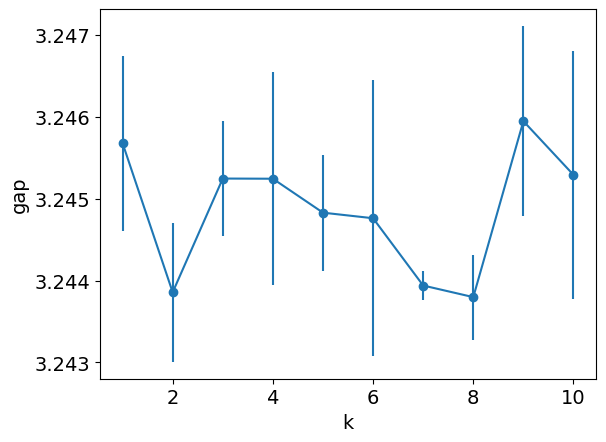

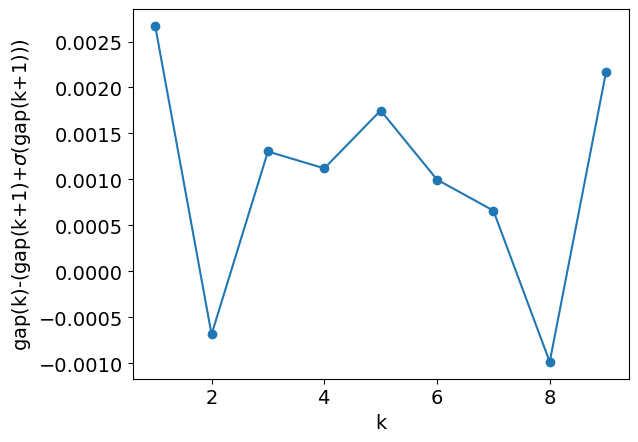

In [47]:
fig, ax = plt.subplots()
plt.errorbar(range(1, k_max+1), optimalK.gap_df['gap_value'], yerr=optimalK.gap_df['sk'], fmt='-o')
plt.ylabel('gap')
plt.xlabel('k')
plt.savefig("gap_new.svg",bbox_inches='tight')
plt.savefig("gap_new.pdf",bbox_inches='tight')
fig, ax = plt.subplots()
plt.plot(range(1, k_max+1), optimalK.gap_df['diff'], '-o')
plt.ylabel('gap(k)-(gap(k+1)+$\sigma$(gap(k+1)))')
plt.xlabel('k')
plt.savefig("diff.svg",bbox_inches='tight')
plt.savefig("diff.pdf",bbox_inches='tight')
# Get the best k which is the first k for which gap(k)-(gap(k+1)-sigma(k+1))>=0
bestK = -1;
for diffI in range(optimalK.gap_df['diff'].shape[0]):
    if optimalK.gap_df['diff'][diffI] > 0 and diffI+1 > 1:
        bestK = diffI+1;
        break;
print(bestK)

In [48]:
# Now get the cluster labels for the raw data
Kmean = KMeans(n_clusters=bestK, random_state=randomState)
#Kmean.fit(clusteringData)
Kmean.fit(clusteringData.astype(float))
centroids = Kmean.cluster_centers_
clusLabels = Kmean.labels_

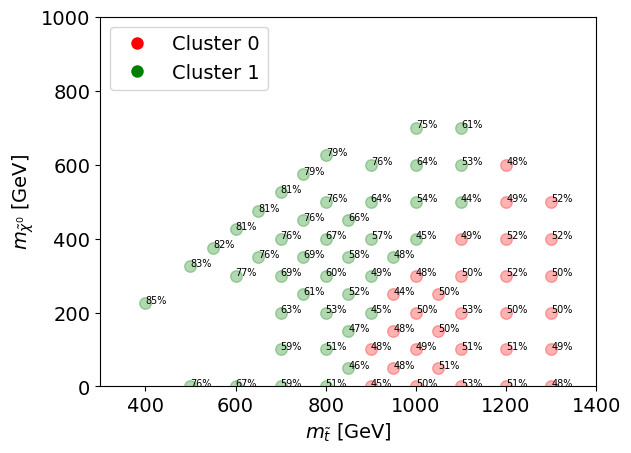

In [49]:
goodSamps = sorted(pandas.unique(allSamps.sampName))
stopLSPMasses = {}
for sampLabel in goodSamps:
    dummy, stopMass, lspMass = sampLabel.split("_")[:3]
    stopMass = int(stopMass)
    lspMass = int(lspMass)
    stopLSPMasses[sampLabel] = (stopMass, lspMass)
    
stopMasses = []
lspMasses = []
# Clusters that contain the highest fraction of a signal are considered the best cluster.
bestClusters = {}
bestClusFracs = {}
for sampLabel in goodSamps:
    
    stopMass = stopLSPMasses[sampLabel][0]
    lspMass = stopLSPMasses[sampLabel][1]
    stopMasses.append(stopMass)
    lspMasses.append(lspMass)
    frac = -99
    bestClus = -1
    for clusI in range(bestK):
        sampIndex = (allSamps.sampName==sampLabel)
        sampClusIndex = (sampIndex) & (clusLabels==clusI)
        clusFrac = 1.*sum(sampClusIndex)/sum(sampIndex)
        if clusFrac > frac:
            frac = clusFrac
            bestClus = clusI
    bestClusters[(stopMass,lspMass)] = bestClus
    bestClusFracs[(stopMass, lspMass)] = frac
        
colors = ['r', 'g', 'b', 'y', 'c', 'k', 'm', 'tab:orange', 'tab:brown']
fig, ax = plt.subplots()
for stopLSPMass in bestClusters:
    plt.scatter(stopLSPMass[0], stopLSPMass[1], c=colors[bestClusters[stopLSPMass]], label=f'Cluster {bestClusters[stopLSPMass]}', alpha=0.3, s=70)
    ax.annotate(f'{round(bestClusFracs[stopLSPMass]*100)}%', stopLSPMass, fontsize=7)

ax.set_xlabel("$m_{\\tilde{t}}$ [GeV]")
ax.set_ylabel("$m_{\\tilde{\chi}^0}$ [GeV]")
ax.set_xlim(300,1400)
ax.set_ylim(0,1000)
handles, labels = plt.gca().get_legend_handles_labels()
sortedLabels = sorted(list(set(labels)))
legHandles = [matplotlib.lines.Line2D(range(1), range(1), color="white", marker='o', markerfacecolor=colors[clusI], markersize=10) for clusI in range(bestK)]
plt.legend(ncol=1, handles=legHandles, labels=sortedLabels, loc='upper left')
plt.savefig(f"grid_postclustering_gap.svg",bbox_inches='tight')
plt.savefig(f"grid_postclustering_gap.pdf",bbox_inches='tight')


24.592042922973633 593.8792724609375 -1457.22021484375 -62.058589935302734 28.464361476898194 69.75808124542236


<ipython-input-50-dbb8586d6de7>:38: UserWarning: No contour levels were found within the data range.
  plt.contour(xx, yy, z, levels=0, colors='g', linewidths=[3])


<ipython-input-50-dbb8586d6de7>:38: UserWarning: No contour levels were found within the data range.
  plt.contour(xx, yy, z, levels=0, colors='g', linewidths=[3])


<ipython-input-50-dbb8586d6de7>:38: UserWarning: No contour levels were found within the data range.
  plt.contour(xx, yy, z, levels=0, colors='g', linewidths=[3])


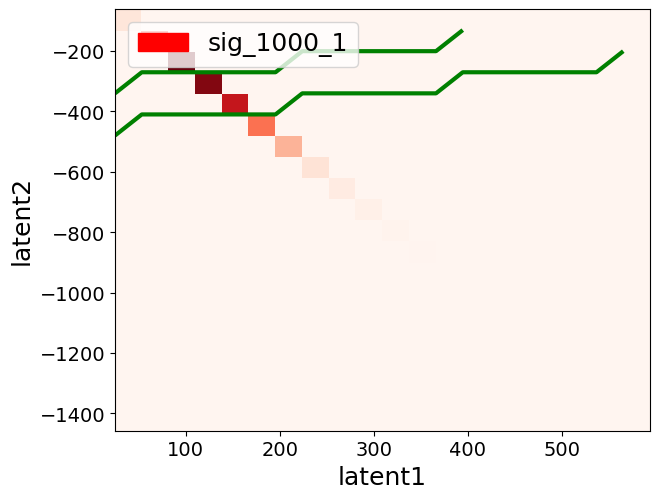

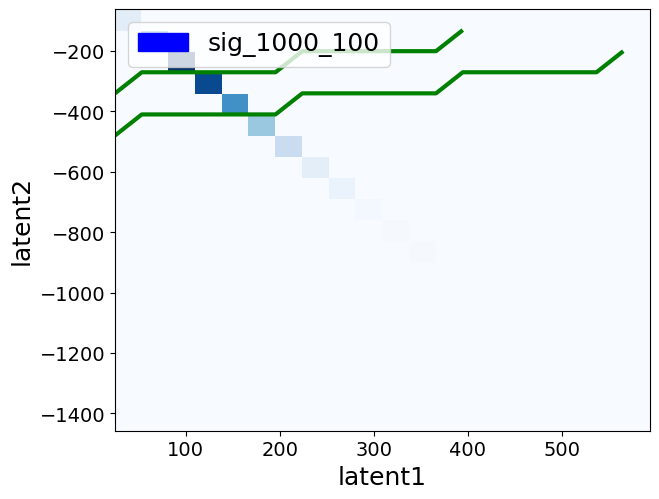

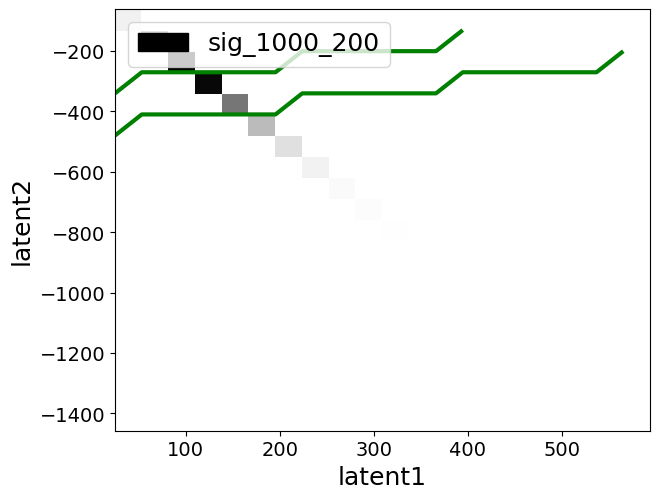

In [50]:
markers = ['s', 'P', 'o']
sampColors = ['r','b', 'k']
clusColors = ['r','k', 'b', 'g', 'y', 'c', 'm']
legHandles = []
for clusColor in clusColors:
    legHandles.append(matplotlib.lines.Line2D([], [], c=clusColor, linewidth=3))
for sampColor in sampColors:
    legHandles.append(matplotlib.lines.Line2D([], [], c=sampColor, linestyle='dashed'))
# Plot the 2D histograms (since we only have two variables that we are clustering in)
# and also plot the cluster boundaries.

# Step size of the mesh. Decrease to increase the quality of the VQ.

# Plot the decision boundary. For that, we will assign a color to each
xMin, yMin = np.min(clusteringData, axis=0)
xMax, yMax = np.max(clusteringData, axis=0)
nBins = 20
dX = (xMax-xMin)/nBins
dY = (yMax-yMin)/nBins
x_min, x_max = xMin,xMax
y_min, y_max = yMin,yMax
print(x_min, x_max, y_min, y_max, dX, dY)
xx, yy = np.meshgrid(np.arange(x_min, x_max, dX), np.arange(y_min, y_max, dY))
# Obtain labels for each point in mesh. Use last trained model.
z = Kmean.predict(np.c_[xx.ravel(), yy.ravel()])
z = z.reshape(xx.shape)
# Put the result into a color plot

bins2d = [[i*dX+xMin for i in range(21)], [i*dY+yMin for i in range(21)]]
colorMaps = [plt.cm.Reds, plt.cm.Blues, plt.cm.Greys]
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
sampLabels = pandas.unique(allSamps.sampName)
for color, cmap, sampLabel in zip(sampColors, colorMaps, sampLabels):
    fig, ax = plt.subplots()
    scaledSampData = allSamps[allSamps.sampName==sampLabel]
    plt.hist2d(scaledSampData['latent1'], scaledSampData['latent2'], bins=bins2d, cmap=cmap)
    plt.contour(xx, yy, z, levels=0, colors='g', linewidths=[3])
    # cluster1Text = ax.text(0.15, 0.05, 'Cluster 1', ha="center", va="center", color=sampColors[2], fontsize=20)
    # cluster2Text = ax.text(0.8, 0.05, 'Cluster 2', ha="center", va="center", color=sampColors[1], fontsize=20)
    # cluster3Text = ax.text(0.15, 0.8, 'Cluster 3', ha="center", va="center", color=sampColors[0], fontsize=20)
    legHandles = [mpatches.Patch(color=color, label=sampLabel)]
    
    # ax.set_ylim(0, 1)
    # ax.set_xlim(0, 1)
    fontsize=18
    ax.set_xlabel('latent1', fontsize=fontsize)
    ax.set_ylabel('latent2', fontsize=fontsize)
    ax.legend(ncol=1, handles=legHandles, fontsize=fontsize, loc=2)
    plt.tight_layout(pad=0.0)
    plt.margins(0,0)
    plt.savefig(f"latent_{sampLabel}_2DHist_postclustering.svg",bbox_inches='tight', pad_inches=0)
    plt.savefig(f"latent_{sampLabel}_2DHist_postclustering.pdf",bbox_inches='tight', pad_inches=0)